In [1]:
import pandas as pd
import numpy as np
import statistics as st
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from scipy import stats
# Let's employ ANOVA
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Regression building
from sklearn.linear_model import LinearRegression
from  matplotlib import pyplot 


In [79]:
def file_opener(adress, invert=False):
    """ Open and cut our file"""
    df_coll = pd.read_excel(adress,sheet_name=None, header=None)
    list_df=[]
    for it in df_coll.values():
        ''' converting angle if needed'''
        if invert==True:
            list_df.append(180-pd.DataFrame(it).loc[1:,1:])
        else:
            list_df.append(pd.DataFrame(it).loc[1:,1:])
    return list_df

def CutData(list_of_df, cut_from=0, cut_to=-1):
    """Cutting off a non-linear part of the curve 
    and extracting mean for each plant"""
    data_cut=[]
    for datafr in list_of_df:
        data_cut.append(datafr.iloc[cut_from:cut_to,:])
    return data_cut

def tukefying(list_of_means):
    '''Converting the data to the edible format for the TukeyHSD'''
    listOM_concat = np.concatenate(list_of_means)
    return pd.DataFrame({'Value': listOM_concat,
                   'Line': np.repeat(['WT', 'PIN7LG', 'PIN7SR', 'pin7_2'], repeats=len(listOM_concat)/4)})

def reg_extractor(dataframe):
    '''Running linear regression for each column of each dataframe 
    and extracting slopes and intercepts as list of dicts'''
    intercept_slope_list = {'int':[], 'slope':[], 'r_sq':[]}        # dict for data gathering
    x= dataframe.index.to_numpy().reshape((-1, 1))      # reshaping x to 2d array   
    y=dataframe.T.to_numpy()        # converting columns to the separate 1d arrays
    for sub_y in y:
        test_model = LinearRegression(fit_intercept=True).fit(x, sub_y)     # fitting   
        intercept_slope_list['r_sq'].append(test_model.score(x, sub_y))     # extracting r^2
        intercept_slope_list['int'].append(test_model.intercept_)           # extracting intercept
        intercept_slope_list['slope'].append(test_model.coef_[0])           # extracting slope
        # and plot what we've got
        prediction = test_model.predict(x)
        pyplot.scatter(x, sub_y)
        pyplot.plot(np.sort(x, axis=0),prediction)
    pyplot.show()
    return pd.DataFrame(intercept_slope_list)

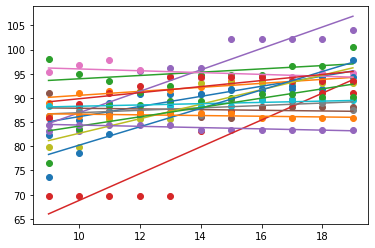

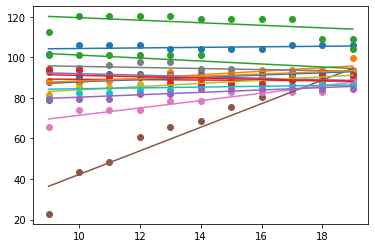

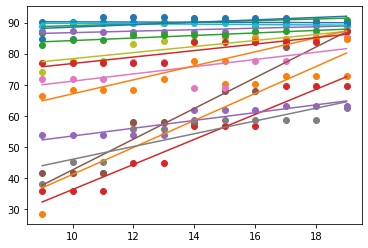

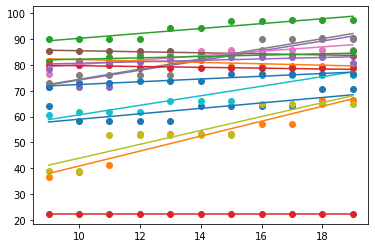

In [80]:
data = file_opener('2021.04_phototropism.xlsx', invert=True)
linear_per_line=CutData(data,8,-1)
wt=reg_extractor(linear_per_line[0])
P7a=reg_extractor(linear_per_line[1])
P7b=reg_extractor(linear_per_line[2])
p7_2=reg_extractor(linear_per_line[3])


In [87]:
r_sq_df=tukefying([wt['r_sq'],P7a['r_sq'], P7b.r_sq, p7_2.r_sq])
slope_df=tukefying([wt.slope,P7a.slope, P7b.slope, p7_2.slope])
intercept_df=tukefying([wt.int,P7a.int, P7b.int, p7_2.int])

In [92]:
# perform Tukey's test for r_sq
tukey_r_sq = pairwise_tukeyhsd(endog=r_sq_df['Value'],
                          groups=r_sq_df['Line'],
                          alpha=0.05)

#display results
print(tukey_r_sq)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
PIN7LG PIN7SR   0.2262 0.0982 -0.0282 0.4806  False
PIN7LG     WT   0.1463 0.4325 -0.1081 0.4007  False
PIN7LG pin7_2   0.3242 0.0072  0.0698 0.5786   True
PIN7SR     WT  -0.0799 0.8193 -0.3343 0.1745  False
PIN7SR pin7_2    0.098 0.7146 -0.1564 0.3524  False
    WT pin7_2   0.1779 0.2608 -0.0765 0.4323  False
---------------------------------------------------


In [93]:
# perform Tukey's test for slope
tukey_slope = pairwise_tukeyhsd(endog=slope_df['Value'],
                          groups=slope_df['Line'],
                          alpha=0.05)

#display results
print(tukey_slope)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
PIN7LG PIN7SR   0.9495 0.2263 -0.3512 2.2502  False
PIN7LG     WT   0.1837    0.9 -1.1171 1.4844  False
PIN7LG pin7_2    0.374  0.858 -0.9267 1.6748  False
PIN7SR     WT  -0.7658 0.4114 -2.0666 0.5349  False
PIN7SR pin7_2  -0.5755 0.6308 -1.8762 0.7253  False
    WT pin7_2   0.1904    0.9 -1.1103 1.4911  False
---------------------------------------------------


In [95]:
# perform Tukey's test for intercept
tukey_intercept = pairwise_tukeyhsd(endog=intercept_df['Value'],
                          groups=intercept_df['Line'],
                          alpha=0.05)

#display results
print(tukey_intercept)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
PIN7LG PIN7SR -27.9864 0.0415 -55.1891 -0.7837   True
PIN7LG     WT  -3.5487    0.9 -30.7513  23.654  False
PIN7LG pin7_2 -23.1662 0.1214 -50.3689  4.0364  False
PIN7SR     WT  24.4377  0.093   -2.765 51.6404  False
PIN7SR pin7_2   4.8201    0.9 -22.3826 32.0228  False
    WT pin7_2 -19.6176 0.2359 -46.8203  7.5851  False
-----------------------------------------------------


In [109]:
pd.concat([pd.DataFrame(['R-square']), pd.DataFrame(tukey_r_sq.summary()), pd.DataFrame(['Slope']),
pd.DataFrame(tukey_slope.summary()), pd.DataFrame(['Intercept']), pd.DataFrame(tukey_intercept.summary())]).to_excel('phototrop_assympt_regr_tukey_output.xlsx')

In [108]:
pd.concat([pd.DataFrame(['sss']), pd.DataFrame(tukey_r_sq.summary())])

,0,1,2,3,4,5,6
0,sss,NaN,NaN,NaN,NaN,NaN,NaN
0,group1,group2,meandiff,p-adj,lower,upper,reject
1,PIN7LG,PIN7SR,0.2262,0.0982,-0.0282,0.4806,False
2,PIN7LG,WT,0.1463,0.4325,-0.1081,0.4007,False
3,PIN7LG,pin7_2,0.3242,0.0072,0.0698,0.5786,True
4,PIN7SR,WT,-0.0799,0.8193,-0.3343,0.1745,False
5,PIN7SR,pin7_2,0.098,0.7146,-0.1564,0.3524,False
6,WT,pin7_2,0.1779,0.2608,-0.0765,0.4323,False


In [50]:
dir(tukey)
# absolutely beautiful command

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_multicomp',
 '_results_table',
 '_simultaneous_ci',
 'confint',
 'data',
 'df_total',
 'groups',
 'groupsunique',
 'meandiffs',
 'plot_simultaneous',
 'pvalues',
 'q_crit',
 'reject',
 'reject2',
 'std_pairs',
 'summary',
 'variance']